<a href="https://colab.research.google.com/github/Thebestneminever/Deep-Learning-Projects/blob/main/Generating_MNIST_data_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs
import glob 
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from IPython import display


In [ ]:
from IPython import display

In [ ]:
# the generator will learn to generate handwritten digits/never seen before like mnist
(train_images,_ ), (test_images,_) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape((train_images.shape[0],28,28,1)).astype("float32")
train_images = (train_images-127.5)/127.5
train_images.shape

(60000, 28, 28, 1)

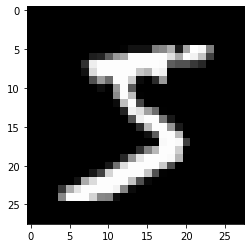

we want to learn how to generate such images


In [ ]:
plt.imshow(train_images[0,:,:,0],cmap="gray")
plt.show()
print("we want to learn how to generate such images")

In [ ]:
batch_size = 256

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(train_images.shape[0]).batch(batch_size)


In [ ]:
# generator model (upsampling/transpose convolutions)
def generator_model():
  model = tf.keras.Sequential(tf.keras.layers.InputLayer(input_shape=(100,))) #(bsz,100)
  model.add(tf.keras.layers.Dense(units=7*7*256, use_bias=False)) # (bsz,7*7*256)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Reshape(target_shape=(7,7,256))) # 7x7x256
  #7x7x256
  assert model.output_shape == (None,7,7,256)
  
  
  model.add(tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=5,strides=1,padding="same",use_bias=False))
  #7x7x128
  assert model.output_shape == (None, 7,7,128)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=5,strides=2,padding="same",use_bias=False))
  # 14x14x64
  assert model.output_shape == (None, 14,14,64)
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.LeakyReLU())

  model.add(tf.keras.layers.Conv2DTranspose(filters=1,kernel_size=5,strides=2,padding="same",use_bias=False,activation="tanh"))
  # note the tanh and no batchnorm 28x28x1
  assert model.output_shape == (None, 28,28,1)
  return model

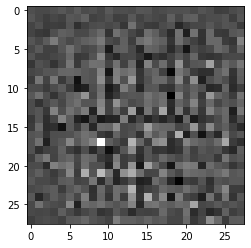

The generator is not yet trained so it outputs garbage images


In [ ]:
# lets check whether or not the generator upsamples or not
generator = generator_model()
noise = tf.random.normal(shape=(1,100))
generated_img  = generator(noise)
plt.imshow(generated_img[0,:,:,0],cmap="gray")
plt.show()
print("The generator is not yet trained so it outputs garbage images")

In [ ]:
# Discriminator (downsampling/classifier)
def discriminator_model():

  # give one batch of real images
  # give one batch of fake images 

  model = tf.keras.Sequential(tf.keras.layers.InputLayer(input_shape=(28,28,1)))
  model.add(tf.keras.layers.Conv2D(filters=64,kernel_size=5,strides=2,padding="same")) #28x28x64
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  assert model.output_shape == (None, 14,14,64)

  model.add(tf.keras.layers.Conv2D(filters=128,kernel_size=5,strides=2,padding="same")) # 28x28x128
  model.add(tf.keras.layers.LeakyReLU())
  model.add(tf.keras.layers.Dropout(0.3))
  assert model.output_shape == (None, 7,7,128)

  model.add(tf.keras.layers.Flatten()) # bsz, 28x28x128
  assert model.output_shape == (None, 7*7*128)

  model.add(tf.keras.layers.Dense(1)) # bsz,1 these are logits
  assert model.output_shape == (None,  1)
  return model



In [ ]:
# checking the discriminator 
discriminator = discriminator_model()
logits = discriminator(generated_img)
print(logits)

tf.Tensor([[-0.00303722]], shape=(1, 1), dtype=float32)


In [ ]:
loss_object  = tf.keras.losses.BinaryCrossentropy(from_logits=True,)

In [ ]:
# Discriminator Loss
# It compares the discriminator's predictions on real images to an array of 1s, 
# and the discriminator's predictions on fake (generated) images to an array of 0s.
def discriminator_loss(real_pred, fake_pred):
  
  # one batch of  preds for the real batch
  # one batch of pred for the fake batch
  
  
  real_label = tf.ones(real_pred.shape)
  fake_label = tf.zeros(fake_pred.shape)

  real_loss = loss_object(real_label,real_pred) 
  fake_loss = loss_object(fake_label, fake_pred)

  total_loss = real_loss + fake_loss # total misclassificatoin loss occured on both batches
  return total_loss

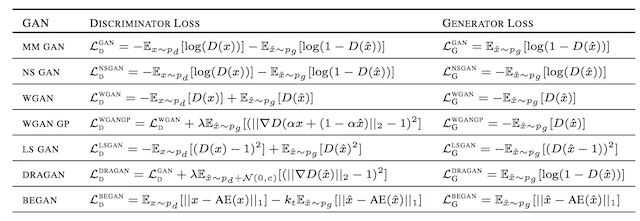

In [ ]:
# Generator Loss (Non Saturating Version/NS GAN)
# the discriminator wants to fool the generator so it wants to max -log(1 - D(G(z)))
# this is equivalent to minimizing -log(D(G(z))) this is aa heauristic which makes the loss of the 
# discriminator non saturating loss hence the NS-GAN
# so this is basically a binary cross entropy with labels as ones and the predictions of disriminator
# on fake images
def generator_loss(fake_pred):
  real_ones = tf.ones(fake_pred.shape)
  return loss_object(real_ones, fake_pred)

In [ ]:
# The discriminator and the generator  optimizer are different since we train two networks separately
generator_optimizer = tf.keras.optimizers.Adam(1e-4) # always one optimizer for one network
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4) # always one optimizer for one network


checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


In [ ]:
EPOCHS = 80
latent_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal(shape=(num_examples_to_generate,latent_dim)) # for gif visualizatoin

In [ ]:
@tf.function
def train_discriminator(real_images):
  latent_space = tf.random.normal(shape=(batch_size,latent_dim)) # noise
  fake_images = generator(latent_space,training=False) # generate fake images
  with tf.GradientTape() as disc_tape: # start tracking now
    logits_of_fake = discriminator(fake_images,training=True) 
    logits_of_real = discriminator(real_images,training=True)
    disc_loss = discriminator_loss(logits_of_real,logits_of_fake)
  trainable_params = discriminator.trainable_variables
  gradients = disc_tape.gradient(disc_loss,trainable_params)
  discriminator_optimizer.apply_gradients(zip(gradients,trainable_params))
  return disc_loss
  

In [ ]:
@tf.function
def train_generator():
  latent_space = tf.random.normal(shape=(batch_size,latent_dim))
  with tf.GradientTape() as gen_tape:
    fake_images = generator(latent_space,training=True)
    logits_of_fake = discriminator(fake_images,training=False)
    gen_loss = generator_loss(logits_of_fake)
  trainable_params = generator.trainable_variables
  gradients = gen_tape.gradient(gen_loss, trainable_params)
  generator_optimizer.apply_gradients(zip(gradients,trainable_params))
  return gen_loss

In [ ]:
def generate_and_save_images(generator_m, epoch, seed_input):
  fake_images = generator_m(seed_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(fake_images.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(fake_images[i, :, :, 0]* 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


In [ ]:
disc_loss = []
gen_loss = []
def train(train_dataset, epochs):
  for epoch in range(epochs): # for each epoch
    dl = 0
    gl = 0
    i = 0
    
    for real_images in train_dataset: # for each mini batch
      i+=1
      dl  += 0.5*(train_discriminator(real_images) + train_discriminator(real_images)) # 2 steps for discriminator
      gl  += train_generator() # one step of generator
    
    dl /= i
    disc_loss.append(dl)
    gl /=i
    gen_loss.append(gl)

    
    if (epoch+1)%15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    
    display.clear_output(wait=True)
    print(f"Epoch: {epoch+1}\nGenerator Loss: {gl} . . . Discriminator Loss: {dl}\n****************\n")
    print(f"Generated Image by network at epoch {epoch}")
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)
  
  
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

      



*****************
Learning To Write . . . Epoch: 1
*****************



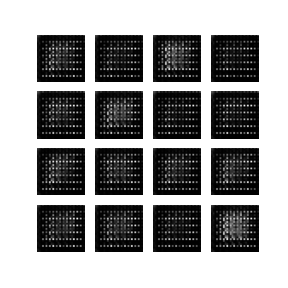


*****************
Learning To Write . . . Epoch: 2
*****************



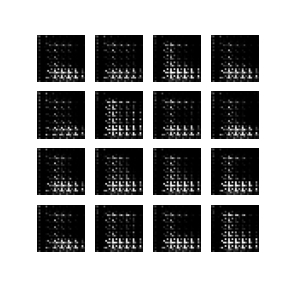


*****************
Learning To Write . . . Epoch: 3
*****************



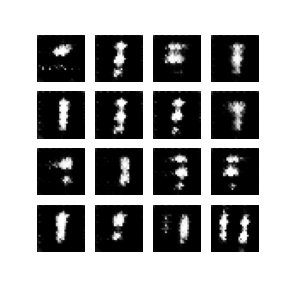


*****************
Learning To Write . . . Epoch: 4
*****************



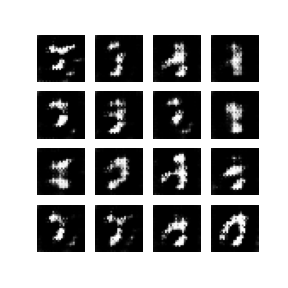


*****************
Learning To Write . . . Epoch: 5
*****************



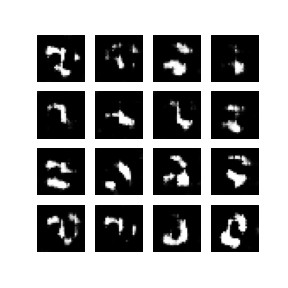


*****************
Learning To Write . . . Epoch: 6
*****************



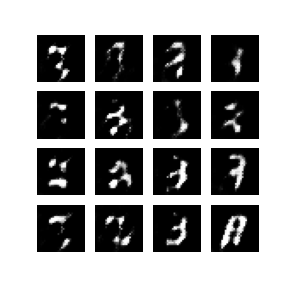


*****************
Learning To Write . . . Epoch: 7
*****************



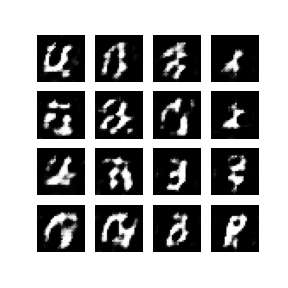


*****************
Learning To Write . . . Epoch: 8
*****************



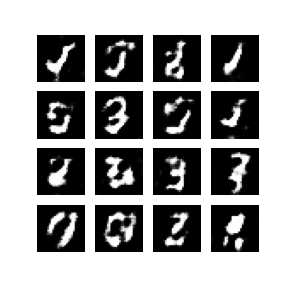


*****************
Learning To Write . . . Epoch: 9
*****************



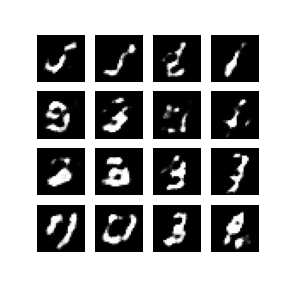


*****************
Learning To Write . . . Epoch: 10
*****************



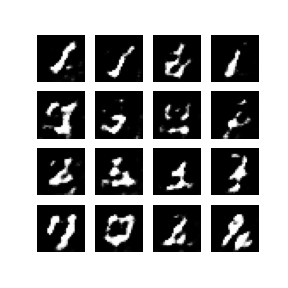


*****************
Learning To Write . . . Epoch: 11
*****************



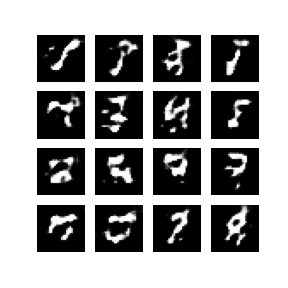


*****************
Learning To Write . . . Epoch: 12
*****************



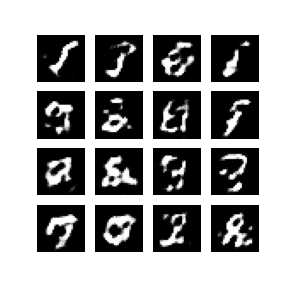


*****************
Learning To Write . . . Epoch: 13
*****************



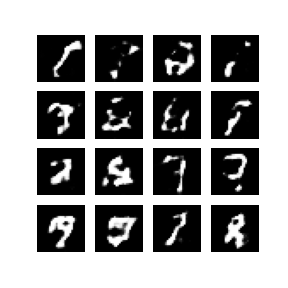


*****************
Learning To Write . . . Epoch: 14
*****************



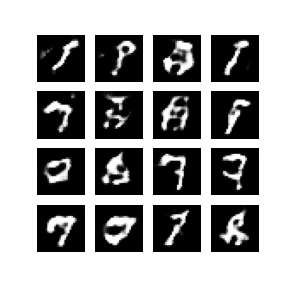


*****************
Learning To Write . . . Epoch: 15
*****************



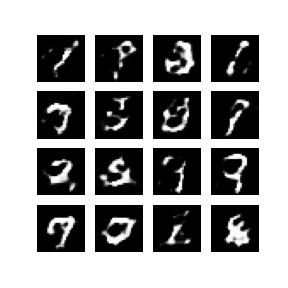


*****************
Learning To Write . . . Epoch: 16
*****************



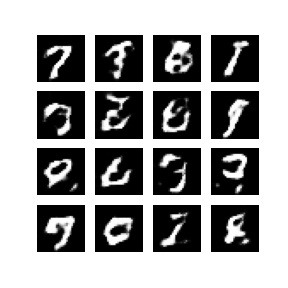


*****************
Learning To Write . . . Epoch: 17
*****************



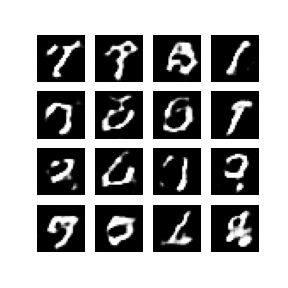


*****************
Learning To Write . . . Epoch: 18
*****************



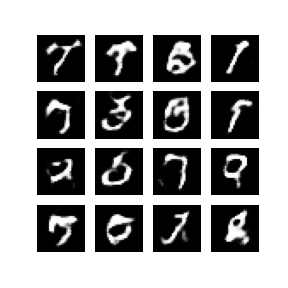


*****************
Learning To Write . . . Epoch: 19
*****************



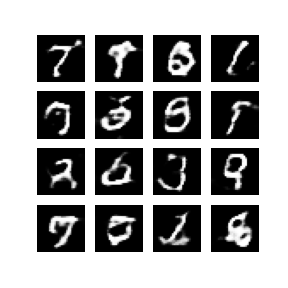


*****************
Learning To Write . . . Epoch: 20
*****************



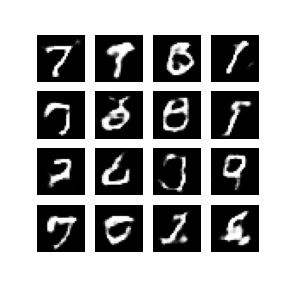


*****************
Learning To Write . . . Epoch: 21
*****************



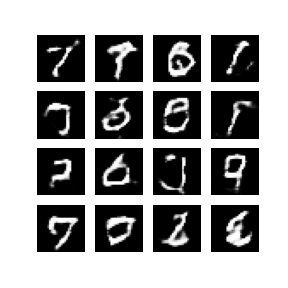


*****************
Learning To Write . . . Epoch: 22
*****************



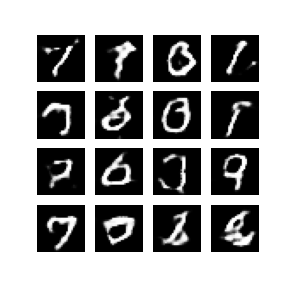


*****************
Learning To Write . . . Epoch: 23
*****************



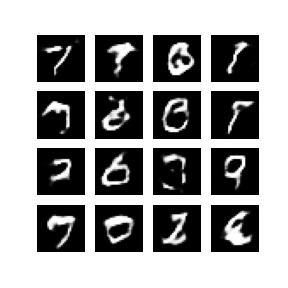


*****************
Learning To Write . . . Epoch: 24
*****************



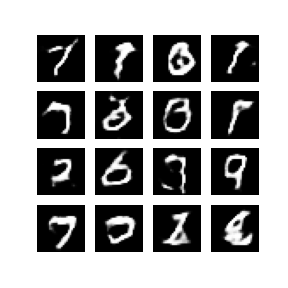


*****************
Learning To Write . . . Epoch: 25
*****************



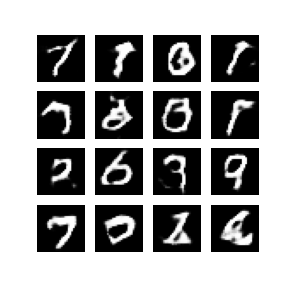


*****************
Learning To Write . . . Epoch: 26
*****************



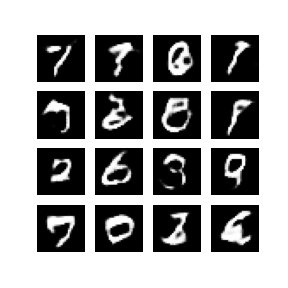


*****************
Learning To Write . . . Epoch: 27
*****************



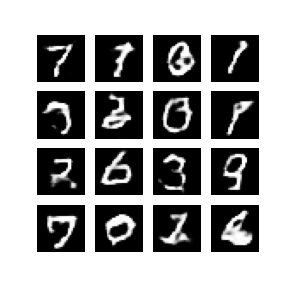


*****************
Learning To Write . . . Epoch: 28
*****************



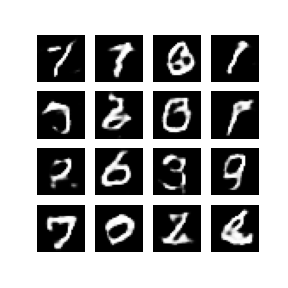


*****************
Learning To Write . . . Epoch: 29
*****************



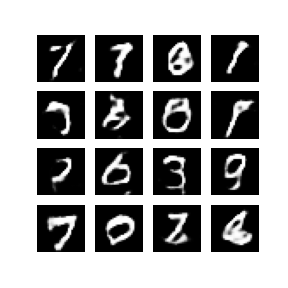


*****************
Learning To Write . . . Epoch: 30
*****************



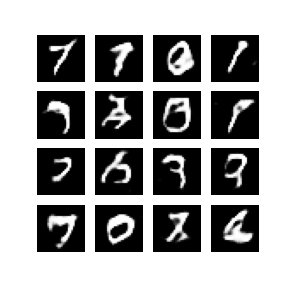


*****************
Learning To Write . . . Epoch: 31
*****************



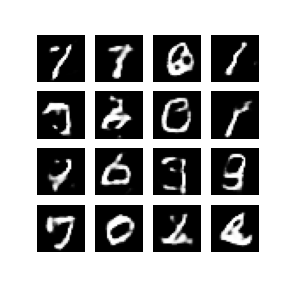


*****************
Learning To Write . . . Epoch: 32
*****************



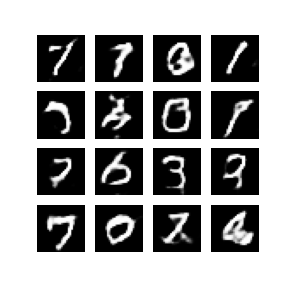


*****************
Learning To Write . . . Epoch: 33
*****************



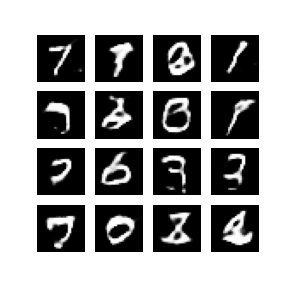


*****************
Learning To Write . . . Epoch: 34
*****************



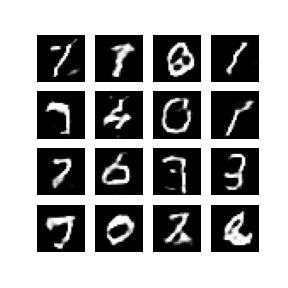


*****************
Learning To Write . . . Epoch: 35
*****************



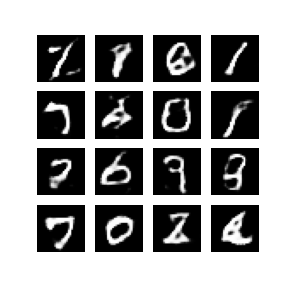


*****************
Learning To Write . . . Epoch: 36
*****************



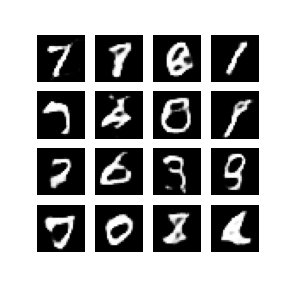


*****************
Learning To Write . . . Epoch: 37
*****************



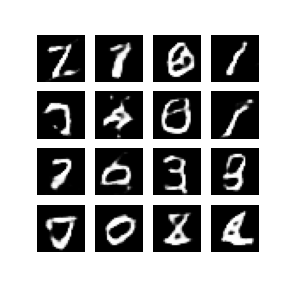


*****************
Learning To Write . . . Epoch: 38
*****************



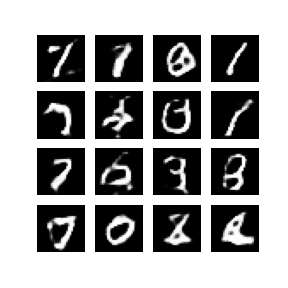


*****************
Learning To Write . . . Epoch: 39
*****************



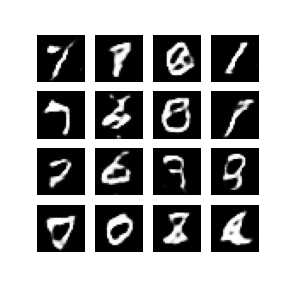


*****************
Learning To Write . . . Epoch: 40
*****************



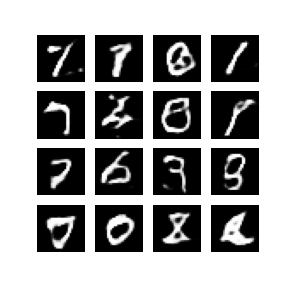


*****************
Learning To Write . . . Epoch: 41
*****************



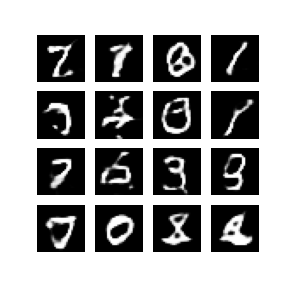


*****************
Learning To Write . . . Epoch: 42
*****************



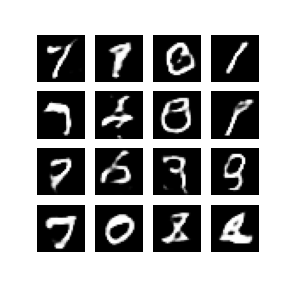


*****************
Learning To Write . . . Epoch: 43
*****************



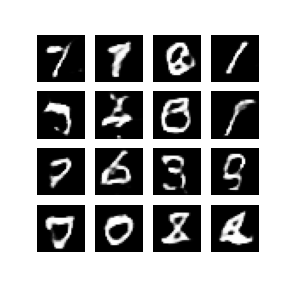


*****************
Learning To Write . . . Epoch: 44
*****************



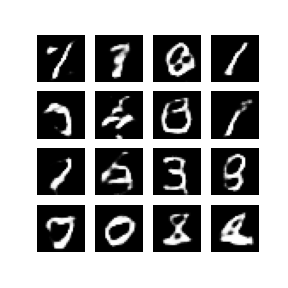


*****************
Learning To Write . . . Epoch: 45
*****************



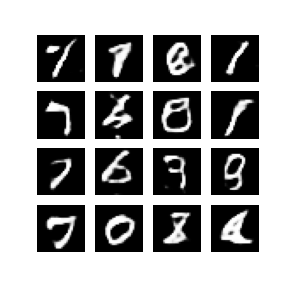


*****************
Learning To Write . . . Epoch: 46
*****************



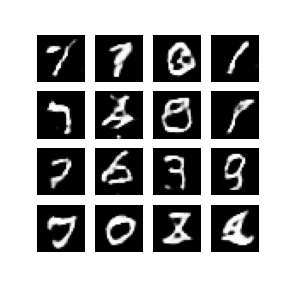


*****************
Learning To Write . . . Epoch: 47
*****************



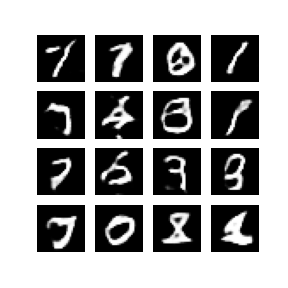


*****************
Learning To Write . . . Epoch: 48
*****************



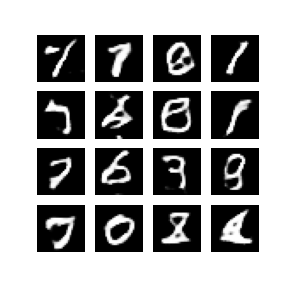


*****************
Learning To Write . . . Epoch: 49
*****************



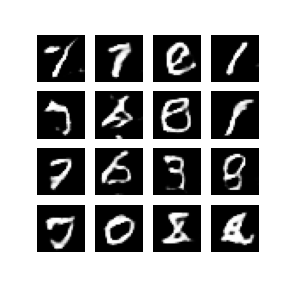


*****************
Learning To Write . . . Epoch: 50
*****************



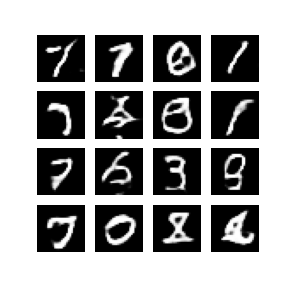


*****************
Learning To Write . . . Epoch: 51
*****************



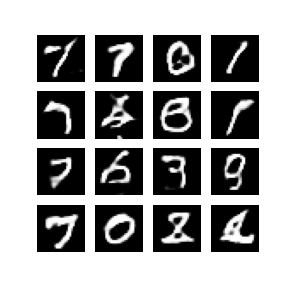


*****************
Learning To Write . . . Epoch: 52
*****************



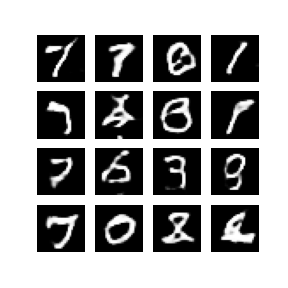


*****************
Learning To Write . . . Epoch: 53
*****************



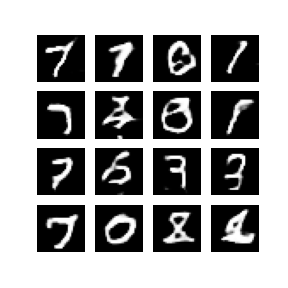


*****************
Learning To Write . . . Epoch: 54
*****************



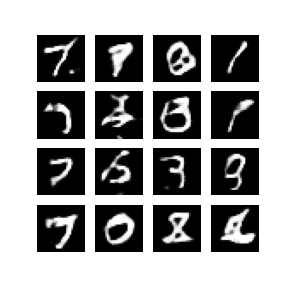


*****************
Learning To Write . . . Epoch: 55
*****************



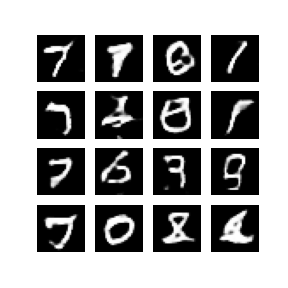


*****************
Learning To Write . . . Epoch: 56
*****************



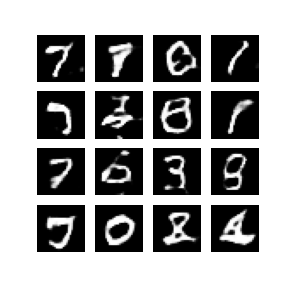


*****************
Learning To Write . . . Epoch: 57
*****************



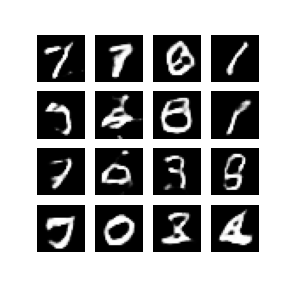


*****************
Learning To Write . . . Epoch: 58
*****************



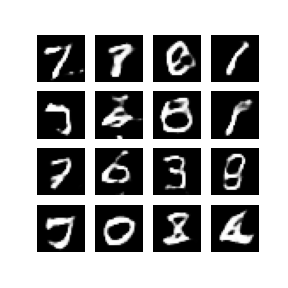


*****************
Learning To Write . . . Epoch: 59
*****************



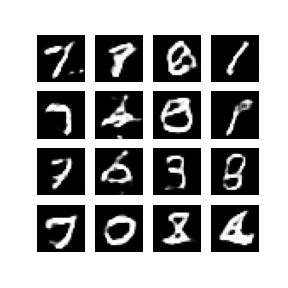


*****************
Learning To Write . . . Epoch: 60
*****************



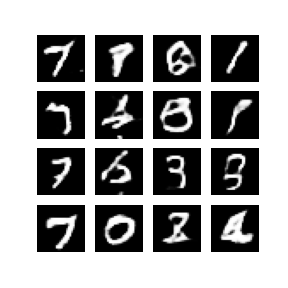


*****************
Learning To Write . . . Epoch: 61
*****************



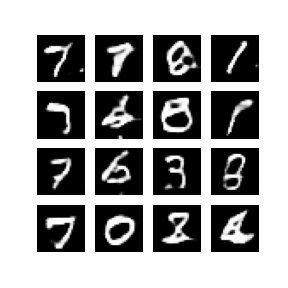


*****************
Learning To Write . . . Epoch: 62
*****************



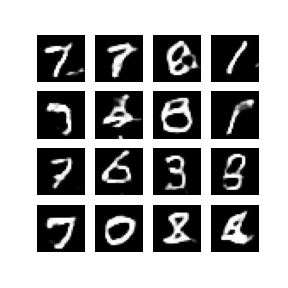


*****************
Learning To Write . . . Epoch: 63
*****************



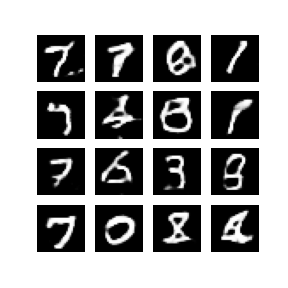


*****************
Learning To Write . . . Epoch: 64
*****************



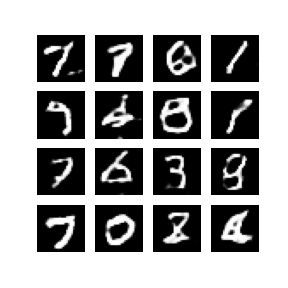


*****************
Learning To Write . . . Epoch: 65
*****************



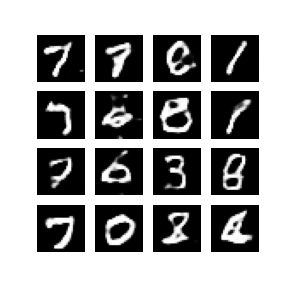


*****************
Learning To Write . . . Epoch: 66
*****************



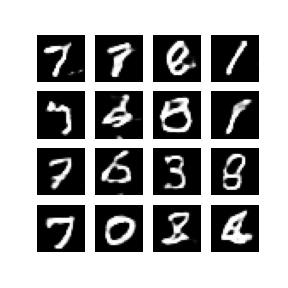


*****************
Learning To Write . . . Epoch: 67
*****************



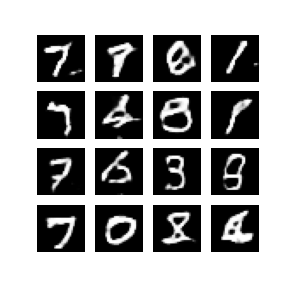


*****************
Learning To Write . . . Epoch: 68
*****************



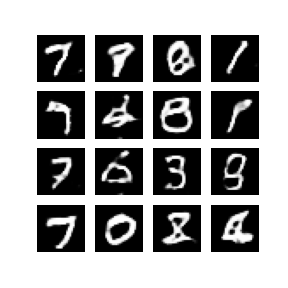


*****************
Learning To Write . . . Epoch: 69
*****************



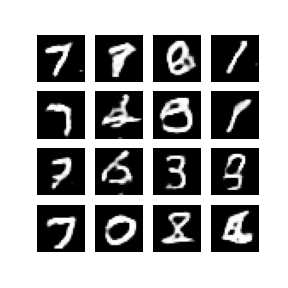


*****************
Learning To Write . . . Epoch: 70
*****************



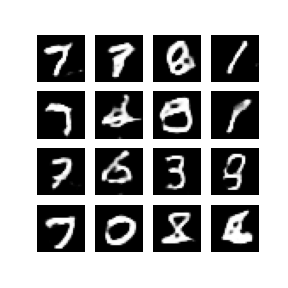


*****************
Learning To Write . . . Epoch: 71
*****************



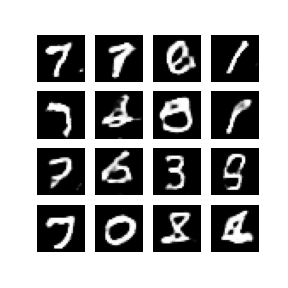


*****************
Learning To Write . . . Epoch: 72
*****************



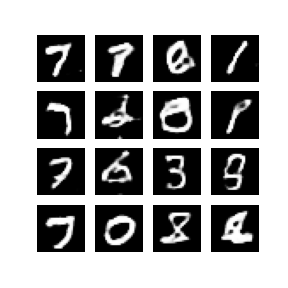


*****************
Learning To Write . . . Epoch: 73
*****************



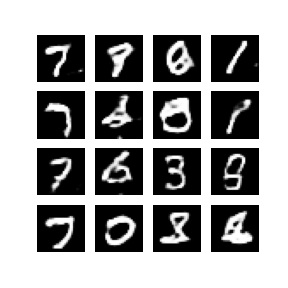


*****************
Learning To Write . . . Epoch: 74
*****************



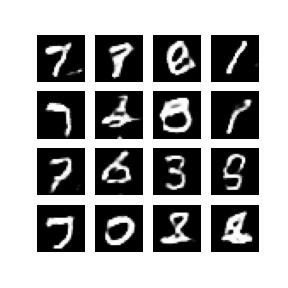


*****************
Learning To Write . . . Epoch: 75
*****************



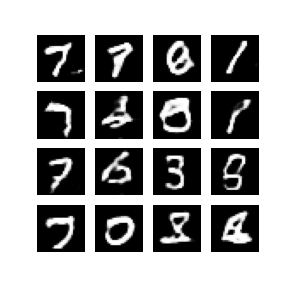


*****************
Learning To Write . . . Epoch: 76
*****************



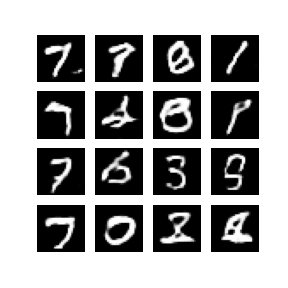


*****************
Learning To Write . . . Epoch: 77
*****************



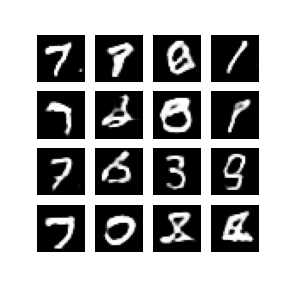


*****************
Learning To Write . . . Epoch: 78
*****************



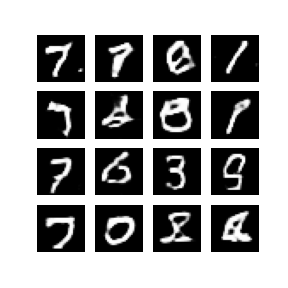


*****************
Learning To Write . . . Epoch: 79
*****************



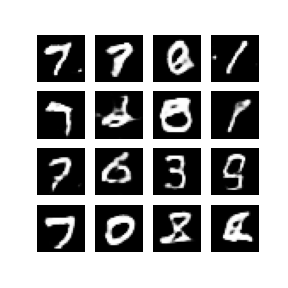


*****************
Learning To Write . . . Epoch: 80
*****************



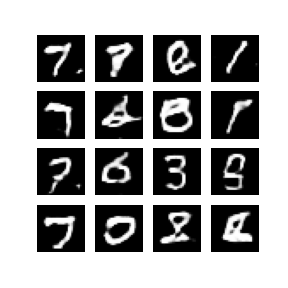

In [ ]:
from IPython.display import Image
for i in range(1,81):
  print(f"\n*****************\nLearning To Write . . . Epoch: {i}\n*****************\n")
  file = 'image_at_epoch_{:04d}.png'.format(i)
  display.display(Image(filename=file))

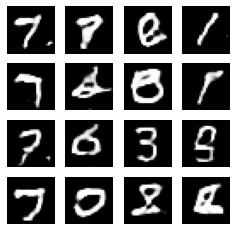

In [ ]:
train(train_dataset,EPOCHS)


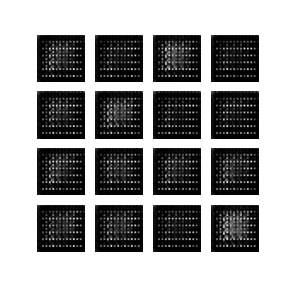

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)
